## Preliminares: transformação de texto em números

![Transformação de texto em números](tokenization.png "Tranformação de texto em números")

## Tokenização

In [205]:
import pandas as pd

df = pd.read_csv('mtsamples.csv')
sentences = df['transcription'].dropna().astype(str).values
sentences[0]

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

### Nível de caractere

In [206]:
class CharacterLevelTokenizer:
    def __init__(self):
        self.token_to_idx = {}
        self.idx_to_token = {}

    def clean_sentence(self, sentence):
        return str(sentence).lower()

    def build_vocab(self, sentences):
        """Monta o vocabulário a partir de uma lista de sentenças."""
        unique_chars = set()
        
        for sentence in sentences:
            cleaned_sentence = self.clean_sentence(sentence)
            unique_chars.update(list(cleaned_sentence))

        self.token_to_idx = {'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3} # Tokens especiais
        for i, char in enumerate(sorted(list(unique_chars)), 4):
            self.token_to_idx[char] = i

        self.idx_to_token = {i: c for c, i in self.token_to_idx.items()}

    def tokenize(self, sentence):
        """Converte uma sentença em uma lista de caracteres (tokens)."""
        cleaned_sentence = self.clean_sentence(sentence)
        return list(cleaned_sentence)

    def convert_tokens_to_ids(self, tokens):
        """Converte uma lista de tokens (caracteres) em seus IDs correspondentes."""
        return [self.token_to_idx.get(token, self.token_to_idx['[UNK]']) for token in tokens]

    def get_vocab_size(self):
        return len(self.token_to_idx)

tokenizer = CharacterLevelTokenizer()
tokenizer.build_vocab(sentences)
print(f"\nTamanho do vocabulário: {tokenizer.get_vocab_size()}")


Tamanho do vocabulário: 84


In [207]:
tokens = tokenizer.tokenize("She has a terrible disease")
print(tokens)

['s', 'h', 'e', ' ', 'h', 'a', 's', ' ', 'a', ' ', 't', 'e', 'r', 'r', 'i', 'b', 'l', 'e', ' ', 'd', 'i', 's', 'e', 'a', 's', 'e']


In [208]:
import re
from collections import Counter

class MostFrequentWordsTokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.token_to_idx = {}
        self.idx_to_token = {}

    def clean_sentence(self, sentence):
        sentence = sentence.lower()
        return re.sub(r'[^a-z0-9\s]', '', sentence)

    def build_vocab(self, sentences):
        words = []
        for sentence in sentences:
            words.extend(self.clean_sentence(str(sentence)).split())

        word_counts = Counter(words)
        most_common_words = word_counts.most_common(self.vocab_size - 4)

        self.token_to_idx = {'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3} # Tokens especiais
        for i, (word, _) in enumerate(most_common_words, 4):
            self.token_to_idx[word] = i

        self.idx_to_token = {i: w for w, i in self.token_to_idx.items()}

    def tokenize(self, sentence):
        cleaned_sentence = self.clean_sentence(str(sentence))
        return cleaned_sentence.split()

    def convert_tokens_to_ids(self, tokens):
        return [self.token_to_idx.get(token, self.token_to_idx['[UNK]']) for token in tokens]
    
    def get_vocab_size(self):
        return len(self.token_to_idx)
    
tokenizer = MostFrequentWordsTokenizer(vocab_size=256)
tokenizer.build_vocab(sentences)

In [209]:
tokenizer.tokenize("She has a terrible disease")

['she', 'has', 'a', 'terrible', 'disease']

### Nível de sub-palavras

In [210]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

class BytePairEncodingTokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        self.tokenizer.pre_tokenizer = Whitespace()
        self.special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]"] # Tokens especiais

    def build_vocab(self, sentences):
        trainer = BpeTrainer(vocab_size=self.vocab_size, special_tokens=self.special_tokens)
        self.tokenizer.train_from_iterator(sentences, trainer=trainer)

    def tokenize(self, text):
        return self.tokenizer.encode(text).tokens

    def convert_tokens_to_ids(self, tokens):
        return [self.tokenizer.token_to_id(token) for token in tokens]
    
    def get_vocab_size(self):
        return self.tokenizer.get_vocab_size()
    
tokenizer = BytePairEncodingTokenizer(vocab_size=2048)
tokenizer.build_vocab(sentences)


In [211]:
tokenizer.tokenize("She has a terrible disease")

['She', 'has', 'a', 'ter', 'r', 'ib', 'le', 'disease']

## Conversão para IDs

In [212]:
tokens = tokenizer.tokenize("She has a terrible disease")
print(tokenizer.convert_tokens_to_ids(tokens))

[229, 218, 65, 157, 82, 274, 129, 590]


## Embeddings

In [213]:
import torch
import torch.nn as nn

VOCAB_SIZE = 256
EMBEDDING_DIM = 768

tokenizer = MostFrequentWordsTokenizer(vocab_size=256)
tokenizer.build_vocab(sentences)

embedding_layer = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM)

In [214]:
tokens = tokenizer.tokenize("She is sick")
token_ids = tokenizer.convert_tokens_to_ids(tokens)
embeddings = embedding_layer(torch.tensor(token_ids))

print(f'Dimensões dos embeddings: {embeddings.shape}\n')

Dimensões dos embeddings: torch.Size([3, 768])



In [215]:
embeddings

tensor([[-0.6247,  1.3177, -0.0310,  ...,  0.4470, -1.1436,  1.2792],
        [ 0.2389, -0.0877, -0.9182,  ...,  0.2894, -1.1512,  0.5023],
        [-0.0336,  0.2910,  1.9524,  ...,  1.4792, -0.9003, -0.1337]],
       grad_fn=<EmbeddingBackward0>)

## Embeddings Posicionais

### Truncamento e padding

In [216]:
class MostFrequentWordsTokenizer:
    def __init__(self, vocab_size, max_len):
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.token_to_idx = {}
        self.idx_to_token = {}

    def clean_sentence(self, sentence):
        sentence = sentence.lower()
        return re.sub(r'[^a-z0-9\s]', '', sentence)

    def build_vocab(self, sentences):
        words = []
        for sentence in sentences:
            words.extend(self.clean_sentence(str(sentence)).split())

        word_counts = Counter(words)
        most_common_words = word_counts.most_common(self.vocab_size - 4)

        self.token_to_idx = {'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3} # Tokens especiais
        for i, (word, _) in enumerate(most_common_words, 4):
            self.token_to_idx[word] = i

        self.idx_to_token = {i: w for w, i in self.token_to_idx.items()}

    def tokenize(self, sentence):
        cleaned_sentence = self.clean_sentence(str(sentence))
        return cleaned_sentence.split()

    def convert_tokens_to_ids(self, tokens):
        return [self.token_to_idx.get(token, self.token_to_idx['[UNK]']) for token in tokens]
    
    def get_vocab_size(self):
        return len(self.token_to_idx)

    ################################################################
    def encode(self, sentences):
        all_input_ids = []
        pad_id = self.token_to_idx['[PAD]']

        for sentence in sentences:
            # Tokeniza e converte para IDs
            tokens = self.tokenize(sentence)
            ids = self.convert_tokens_to_ids(tokens)

            # Truca sequencia se maior que max_len
            if len(ids) > self.max_len:
                ids = ids[:self.max_len]
            
            # Completa com [PAD] se menor que max_len
            padding_len = self.max_len - len(ids)
            ids.extend([pad_id] * padding_len)

            all_input_ids.append(ids)
        
        return torch.tensor(all_input_ids, dtype=torch.long)
    ################################################################


### Tamanho máximo de sequência

In [217]:
TAMANHO_MAX_SEQ = 8

tokenizer = MostFrequentWordsTokenizer(vocab_size=256, max_len=TAMANHO_MAX_SEQ)
tokenizer.build_vocab(sentences)

token_ids = tokenizer.encode(["She has the flu",
                        "He is sick",
                        "They have travelled to China in the last weekeend. They could have been infected with covid-19."])
print(token_ids.shape)


torch.Size([3, 8])


In [218]:
token_ids

tensor([[ 15,  24,   4,   1,   0,   0,   0,   0],
        [ 18,  12,   1,   0,   0,   0,   0,   0],
        [222,  49,   1,   8,   1,  11,   4, 218]])

### Embedding Posicionais aprendíveis

```python

In [219]:
embeddings_posicionais = nn.Embedding(TAMANHO_MAX_SEQ, EMBEDDING_DIM)

### Embeddings posicionais absolutos (Senóides)

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

In [222]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        positional_embeddings = torch.zeros(max_len, d_model)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        indices = torch.arange(0, d_model, 2).float()
        
        exponent = indices / d_model
        
        denominator = torch.pow(10000, exponent)
        
        argument = position / denominator

        positional_embeddings[:, 0::2] = torch.sin(argument)
        positional_embeddings[:, 1::2] = torch.cos(argument)
        
        self.register_buffer('positional_embeddings', positional_embeddings.unsqueeze(0))

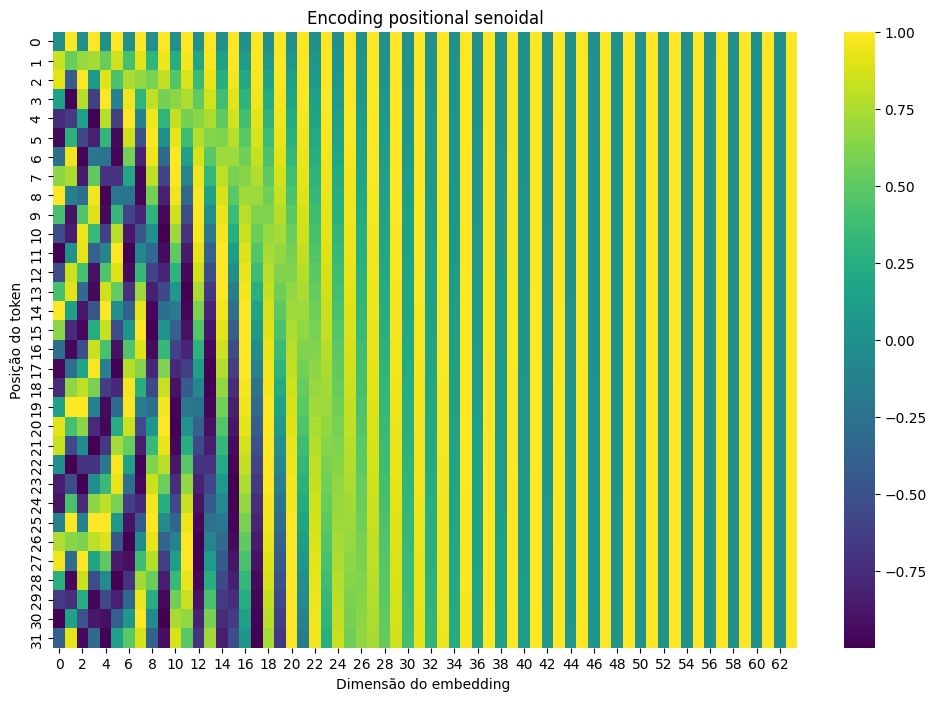

In [ ]:
def plot_positional_embeddings():
    d_model = 64
    max_len = 32
    
    pos_encoder = SinusoidalPositionalEmbedding(d_model, max_len)
    
    pe_matrix = pos_encoder.positional_embeddings.squeeze(0).numpy()
    plt.figure(figsize=(12, 8))
    sns.heatmap(pe_matrix, cmap="viridis", cbar=True)
    plt.title("Encoding positional senoidal")
    plt.xlabel("Dimensão do embedding ")
    plt.ylabel("Posição do token")
    plt.show()

plot_positional_embeddings()

### Analogia com números binários

\begin{array}{|c|c|c|c|}
\hline
\textbf{Número} & \textbf{$2^2$} & \textbf{$2^1$} & \textbf{$2^0$} \\
\hline
\textbf{0} & 0 & 0 & 0 \\
\textbf{1} & 0 & 0 & 1 \\
\textbf{2} & 0 & 1 & 0 \\
\textbf{3} & 0 & 1 & 1 \\
\textbf{4} & 1 & 0 & 0 \\
\textbf{5} & 1 & 0 & 1 \\
\hline
\end{array}